In [39]:


import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns

import math


import numpy as np
import pandas as pd
import time

import pandas as pd
from datetime import datetime
from datetime import date
from datetime import timedelta

import data_scraper_NDBC as scraper
import plotting_functions

from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.linear_model import LinearRegression

import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


In [2]:
#little function for outputing the number of missing values for each column
def get_nan_count(df):
    missing_values_count = df.isnull().sum()
    print(missing_values_count)

In [3]:
#Format a dataframe after impoting from SQL
def format_df(df_in):
    df=df_in.copy(deep=True)
    df["datetime"] = pd.to_datetime(df["datetime"])
    df=df.set_index('datetime')
    df["date"] = pd.to_datetime(df["date"])
    return df

In [4]:
con = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('NDBC_historical_raw_data',), ('NDBC_historical_raw_data_St#{STATIONNUMBER}',), ('NDBC_historical_raw_data_St{STATIONNUMBER}',), ('NDBC_historical_raw_data_St46054',), ('NDBC_historical_cleaned_data',)]


In [5]:
#Query cleaned data from DB
conn = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
df_cleaned = pd.read_sql_query("SELECT * FROM NDBC_historical_cleaned_data", conn, index_col=None)

In [6]:
df_engineered=format_df(df_cleaned)

In [7]:
df_engineered['PRES']=df_engineered['PRES'].apply(lambda x: x/1013.25 )

In [8]:
#little function for outputing the number of missing values for each column
get_nan_count(df_engineered)


WDIR    0
WSPD    0
GST     0
PRES    0
ATMP    0
WTMP    0
date    0
dtype: int64


In [9]:
df_engineered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93812 entries, 2003-06-06 14:00:00 to 2014-02-17 09:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   WDIR    93812 non-null  float64       
 1   WSPD    93812 non-null  float64       
 2   GST     93812 non-null  float64       
 3   PRES    93812 non-null  float64       
 4   ATMP    93812 non-null  float64       
 5   WTMP    93812 non-null  float64       
 6   date    93812 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 5.7 MB


array([<AxesSubplot:title={'center':'Time Plot of ATMP'}, xlabel='date', ylabel='ATMP'>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

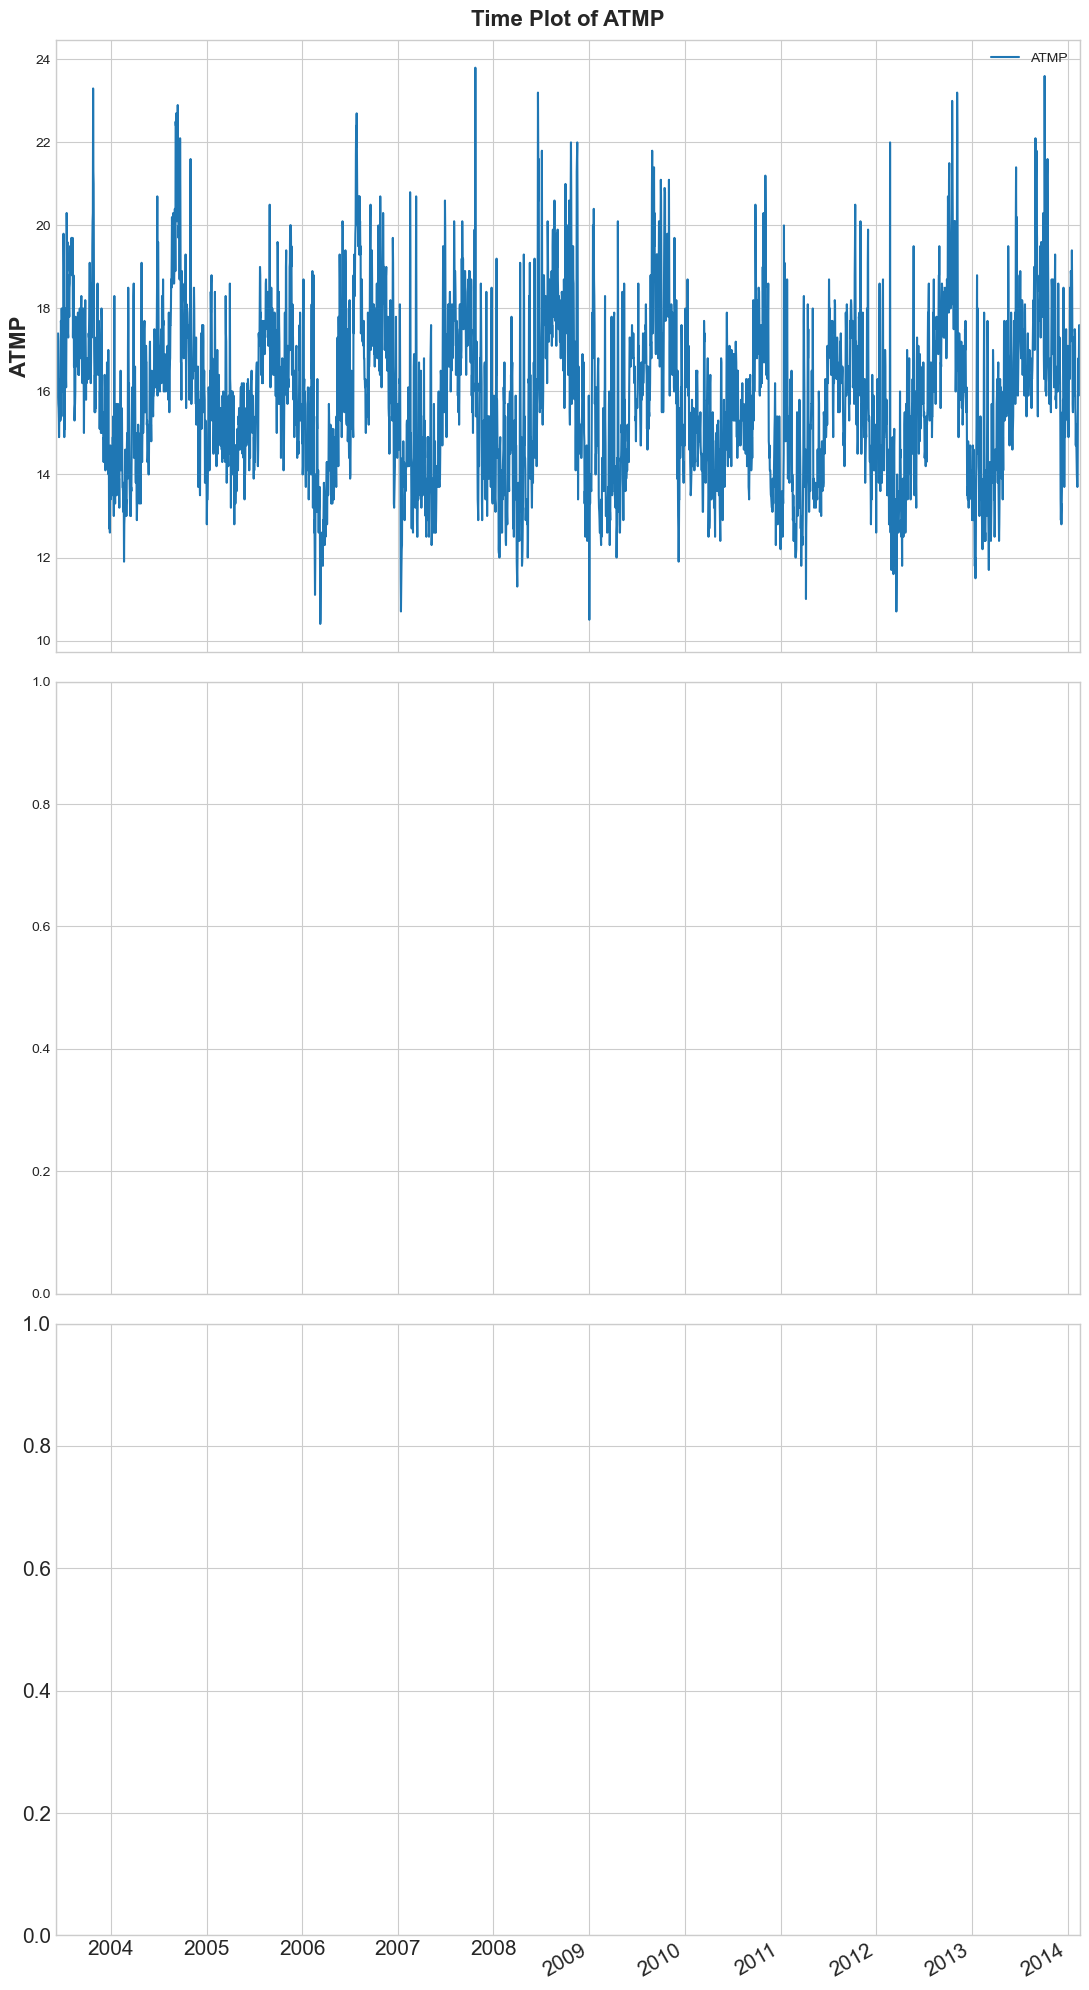

In [40]:
plotting_functions.timeseries_plot_grid(df_engineered,'date', ['ATMP','WTMP','PRES'])

In [11]:
df_engineered= df_engineered.resample("D").max()
df_engineered['date']=df_engineered.index

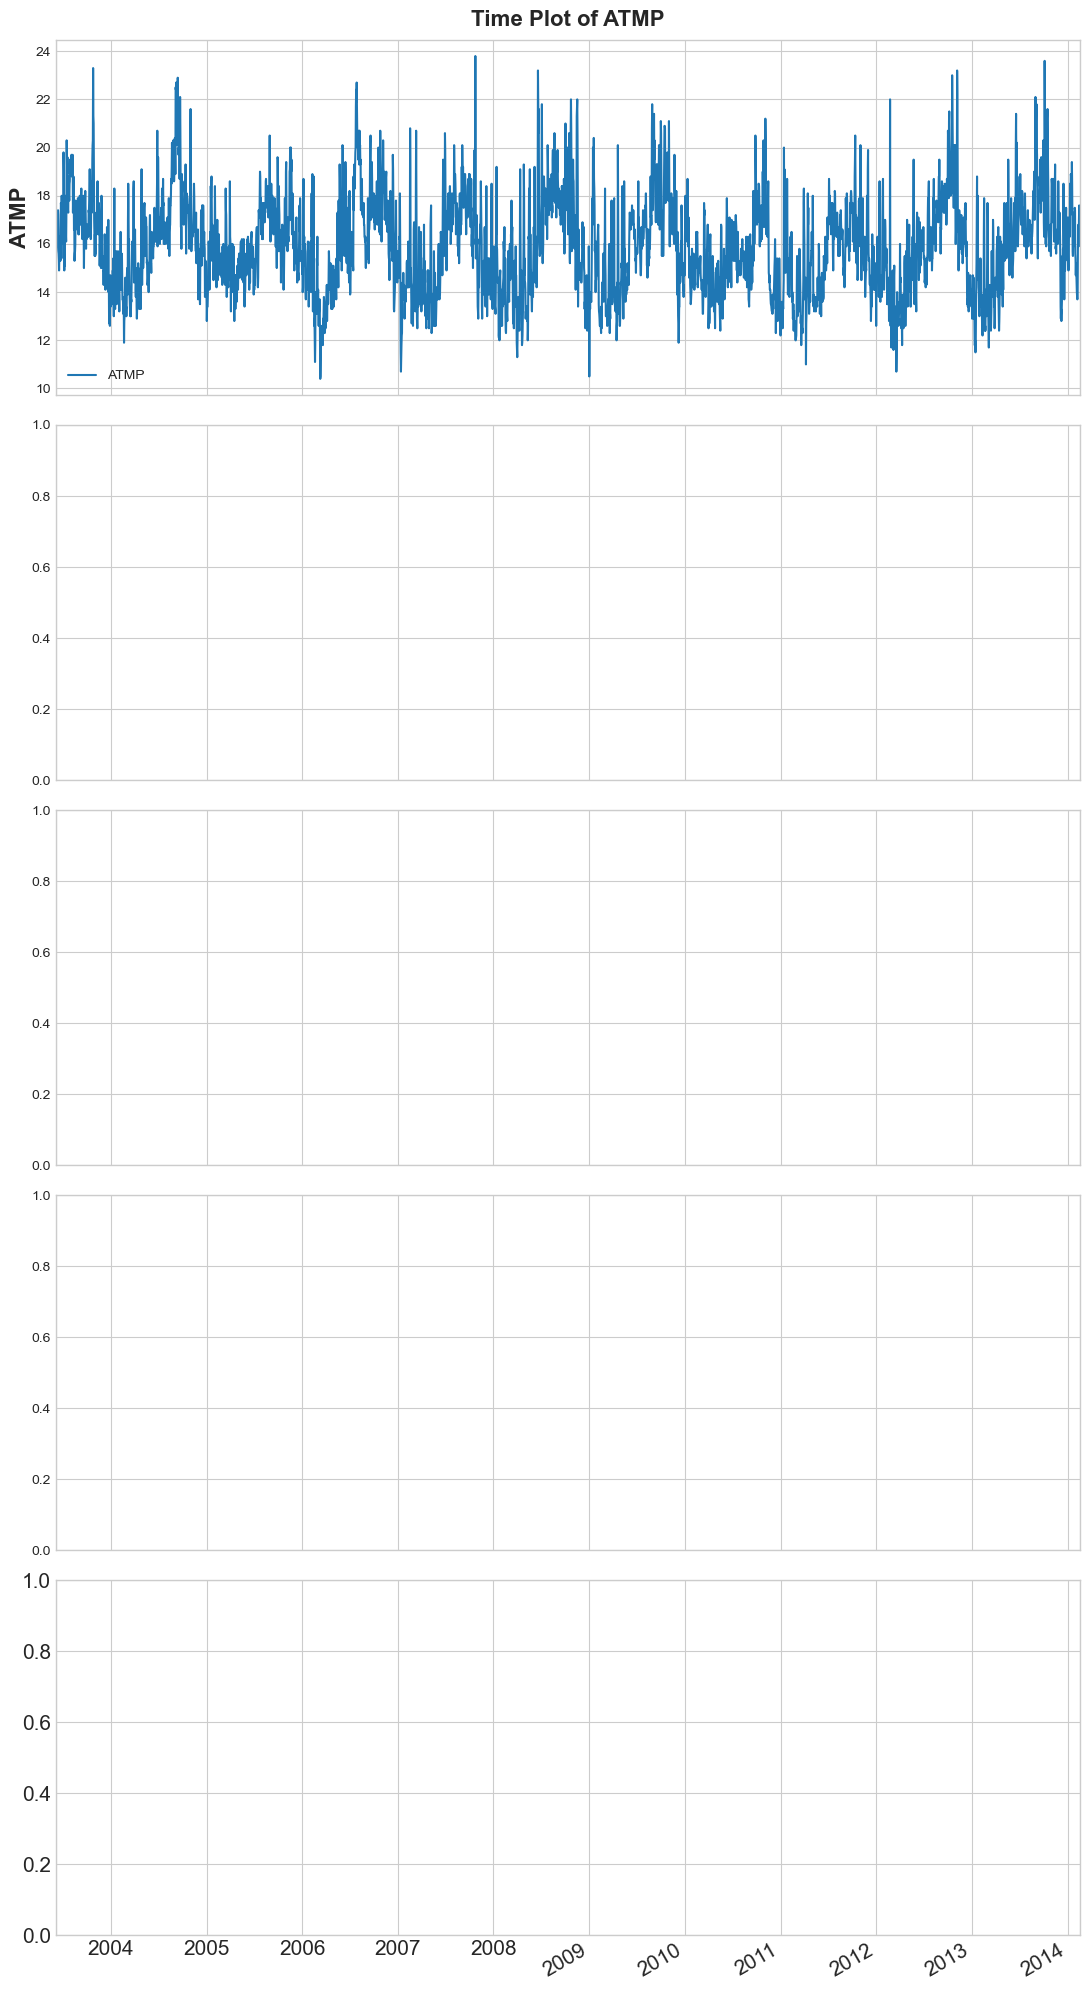

In [38]:
fig=plotting_functions.timeseries_plot_grid(df_engineered,'date', ['ATMP','WTMP','PRES', 'WSPD','GST'])

In [13]:
df_engineered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3910 entries, 2003-06-06 to 2014-02-17
Freq: D
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   WDIR    3910 non-null   float64       
 1   WSPD    3910 non-null   float64       
 2   GST     3910 non-null   float64       
 3   PRES    3910 non-null   float64       
 4   ATMP    3910 non-null   float64       
 5   WTMP    3910 non-null   float64       
 6   date    3910 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 244.4 KB


In [14]:
df_engineered['timestep']=np.arange(len(df_engineered.index))

In [45]:
def lag_plots(num_lags, df_in, target_column, lag_column='', num_graph_rows=2):

    num_graph_cols=math.ceil(float(num_lags)/num_graph_rows)

    df=df_in.copy(deep=True)

    fig, ax = plt.subplots(num_graph_rows, num_graph_cols)
    
    plt.rc("figure", figsize=(5*num_graph_cols,5*num_graph_rows),titlesize=12,titleweight='bold', autolayout=True)
    plt.rc("axes", labelweight="bold", labelsize='Large', titleweight="bold", titlesize=16, titlepad=10)

    if len(lag_column)==0:
        lag_column=target_column
        
    for i in range(num_lags):
        lag=i+1
        new_lag_column=f'{lag_column}_lag_{lag}'
        df[new_lag_column]=df[lag_column].shift(lag)
        
            
        X=df.loc[:,[new_lag_column]]
        X.dropna(inplace=True)

        y=df_engineered.loc[:,target_column]

        y,X=y.align(X, join='inner')

        model=LinearRegression()
        model.fit(X,y)

        y_pred=pd.Series(model.predict(X), index=X.index)

        row=i//num_graph_cols
        col=i-(num_graph_cols*row)

        ax[row,col].plot(X[f'{lag_column}_lag_{lag}'], y, '.', color='0.25')
        ax[row,col].plot(X[f'{lag_column}_lag_{lag}'], y_pred, color='red')
        # ax[row,col].set_aspect('equal')
        ax[row,col].set_ylabel(f'{target_column}', fontsize=12)
        ax[row,col].set_xlabel(f'{lag_column}_lag_{lag}', fontsize=12)
        ax[row,col].set_title(f'Lag {lag}')

  




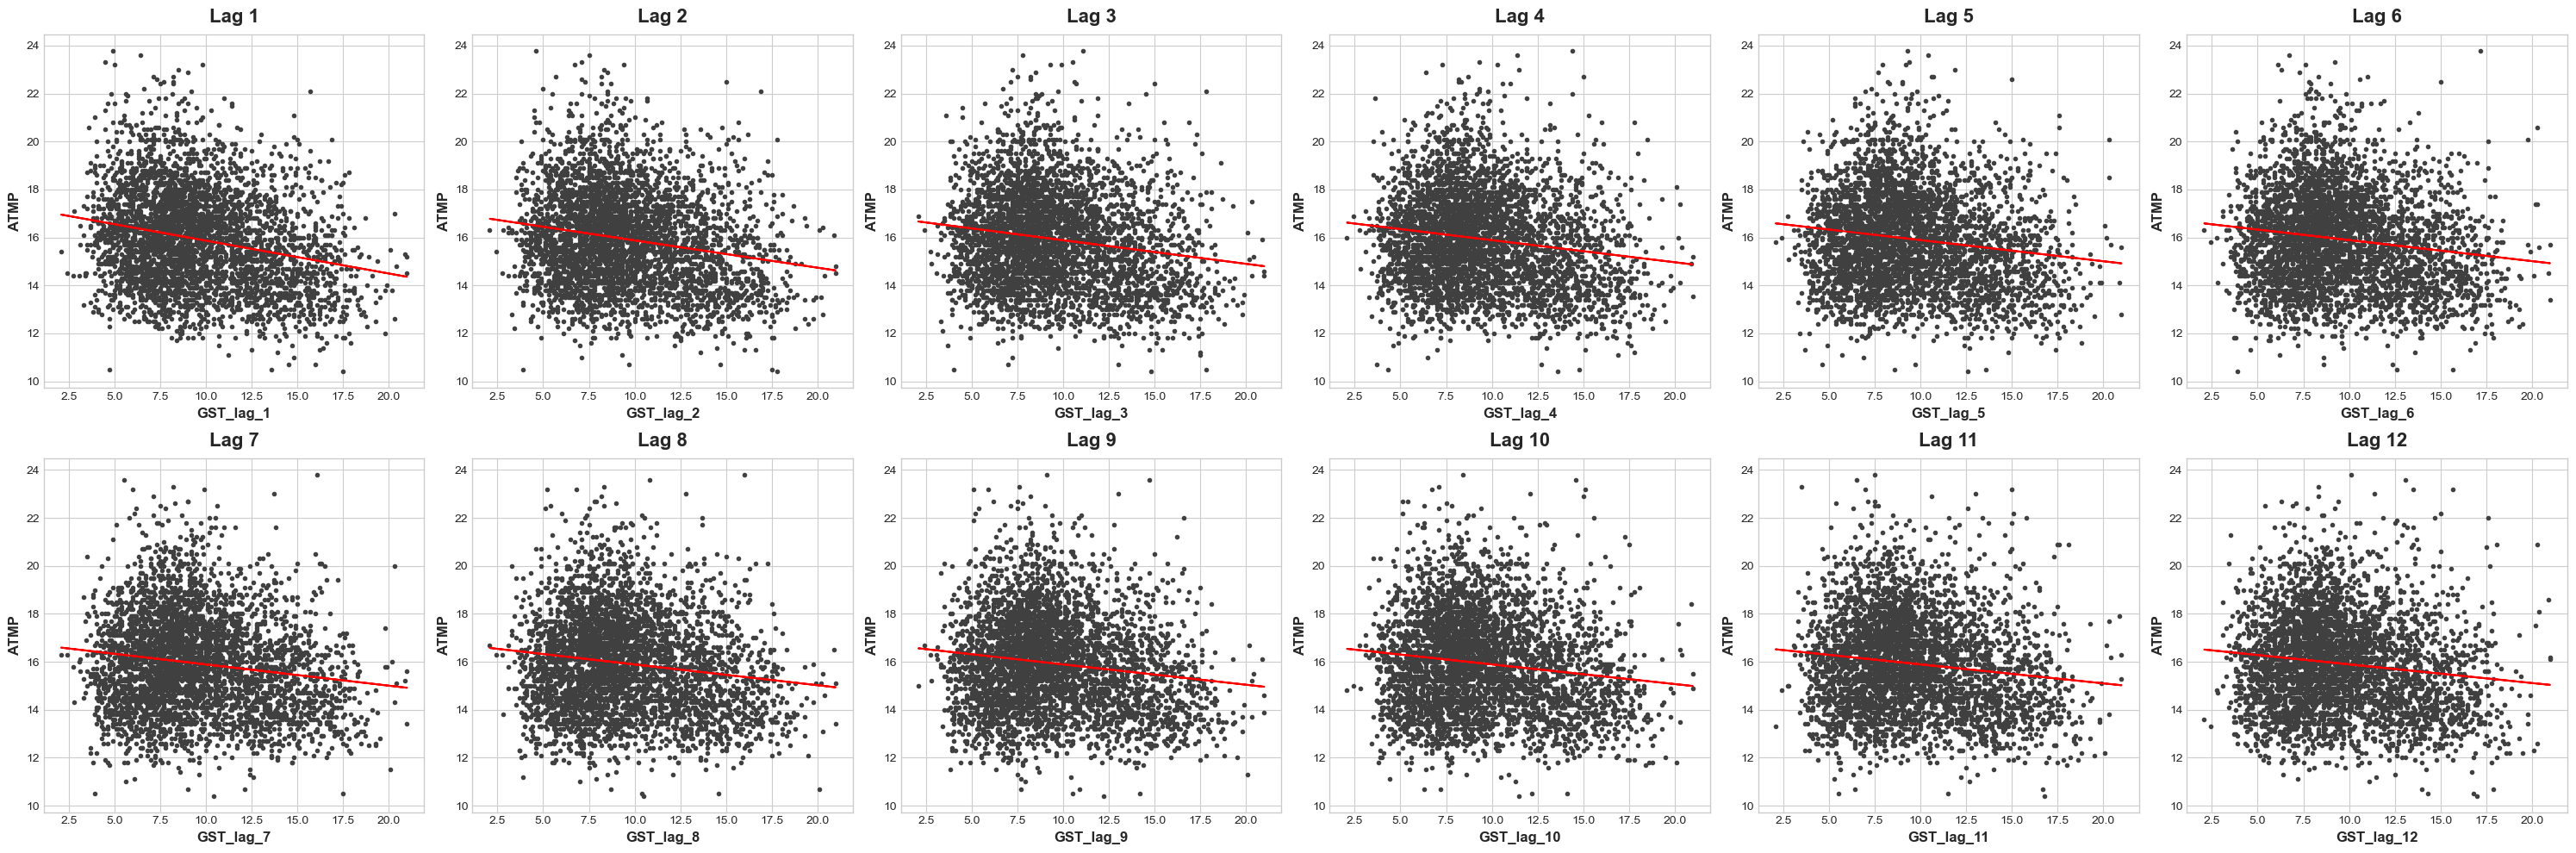

In [46]:
lag_plots(12, df_engineered, 'ATMP', lag_column='GST')

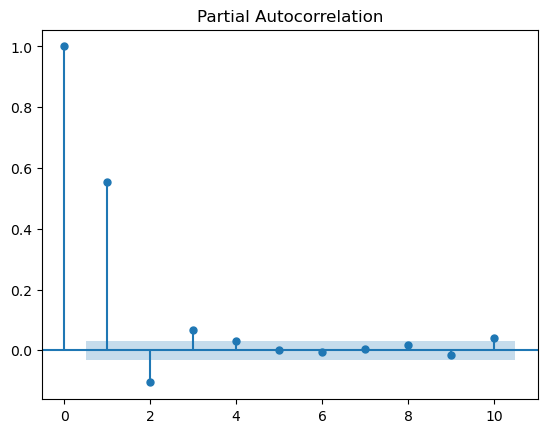

In [17]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
fig=plot_pacf(df_engineered['WSPD'], lags=10)

In [18]:
# Seasonal plot and periodogram functions adapted from https://www.kaggle.com/code/ryanholbrook/seasonality

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))


def seasonal_plot(X, y, period, freq, ax=None):
    plt.style.use("seaborn-whitegrid")
    plt.rc("figure", autolayout=True, figsize=(11, 5))
    if ax is None:
        fig, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique())
    ax = sns.lineplot(x=freq, y=y, hue=period, data=X, ci=False, ax=ax, palette=palette,legend=False)

    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, xy=(1, y_), xytext=(6, 0), color=line.get_color(), xycoords=ax.get_yaxis_transform(), textcoords="offset points", size=14, va="center")
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):

    plt.style.use("seaborn-whitegrid")
    plt.rc("figure", autolayout=True, figsize=(11, 5))

    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    if ax is None:
        fig, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels( [ "Annual (1)", "Semiannual (2)", "Quarterly (4)", "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", "Weekly (52)", "Semiweekly (104)"],rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='WSPD'>

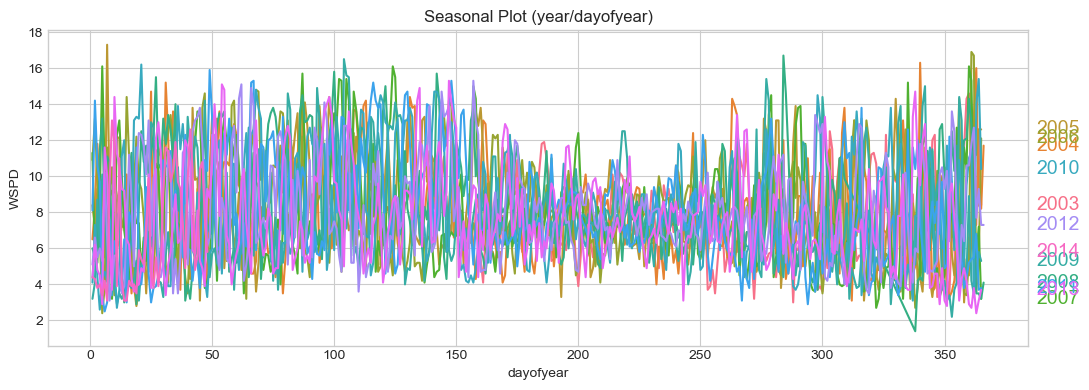

In [22]:
X = df_engineered.copy()

X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, ax = plt.subplots( figsize=(11, 4))
seasonal_plot(X, y="WSPD", period="year", freq="dayofyear", ax=ax)


<ipython-input-41-f7e67bcfb6c5>:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  plot_periodogram(df_engineered['ATMP'])


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

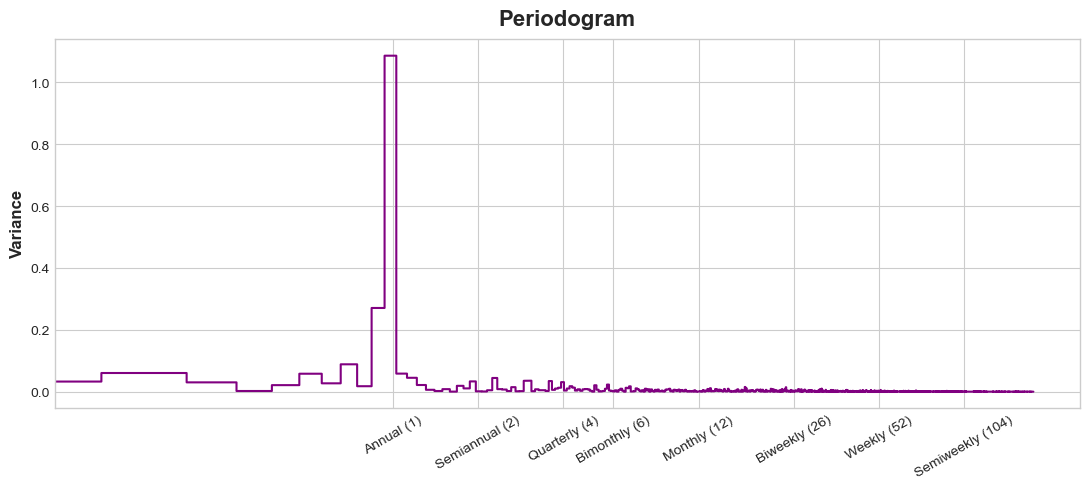

In [41]:
plot_periodogram(df_engineered['ATMP'])